<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/rotating_voxelspace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal: rotate 3d voxelized maps
* this involves several steps
  * coming up with xyz points that describe the voxel
  * rotating the points
  * interpolating the map at the new points

# Setup

In [2]:
!pip install raster_geometry # good for geometric shapes on voxelized arrays
import raster_geometry

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
from scipy.ndimage import rotate
from scipy.spatial import cKDTree

def doplt(arr_2d): return plt.imshow(arr_2d,cmap='gray')

In [4]:
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/5e9dff4905670ff459412120ae6da5583e91e3e6/src/coords.py # my own code
import coords

--2021-05-12 20:22:54--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/5e9dff4905670ff459412120ae6da5583e91e3e6/src/coords.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2803 (2.7K) [text/plain]
Saving to: ‘coords.py.2’

coords.py.2         100%[===================>]   2.74K  --.-KB/s    in 0s      

2021-05-12 20:22:54 (47.2 MB/s) - ‘coords.py.2’ saved [2803/2803]



# rotation in 2D

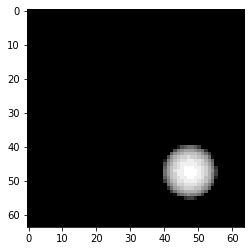

In [77]:
N = 64
sphere = raster_geometry.sphere([N,N,N],radius=N//8,position=.75).astype(np.float32)
circle = sphere.sum(-1)
doplt(circle)

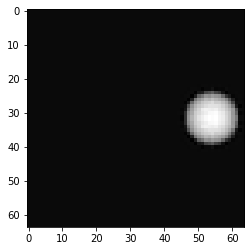

In [78]:
doplt(rotate(circle,angle=45,reshape=False))

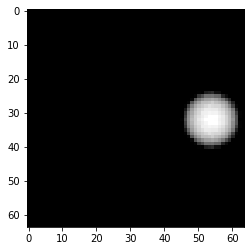

In [79]:
xy = coords.coords_n_by_d(N=N,d=2)
R = coords.EA_to_R3(phi=np.pi/4,theta=0)[:2,:2] # rotation about z axis 
xy_rot = (R.T.dot(xy.T) + N//2) # rotate frame vs rotate object
circle_rot = map_coordinates(circle,xy_rot,order=1).reshape(N,N) # order 1 for linear. otherwise might be too slow for higher order
doplt(circle_rot)

# rotation in 3D

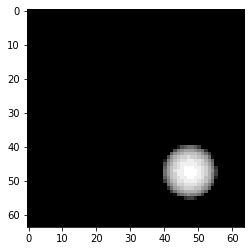

In [65]:
N = 64
sphere = raster_geometry.sphere([N,N,N],radius=N//8,position=.75).astype(np.float32)
doplt(sphere.sum(-1))

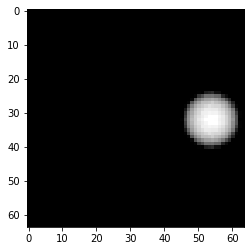

In [80]:
xyz = coords.coords_n_by_d(N=N,d=3) # xyz points cooresponding to the voxel coordinates
R = coords.EA_to_R3(phi=np.pi/4,theta=0)
xyz_rot = (R.T.dot(xyz.T) + N//2)
sphere_rot = map_coordinates(sphere,xyz_rot,order=1).reshape(N,N,N)
doplt(sphere_rot.sum(-1))

In [73]:
xyz_rot.shape

(3, 262144)

In [74]:
np.unique(sphere.shape).size == 1

True

## rotate_map_3d function

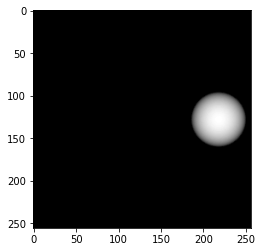

In [90]:
def rotate_map_3d(map_3d, rot,order=1,xyz=None):
  """
  rotate 3d voxelized maps
  this involves several steps
  1. coming up with xyz points that describe the voxel. 
    we have a 3 vector for each voxel. this is made by `coords.coords_n_by_d(N=N,d=2)` and matches the way a 3d array is reshaped. 
    it assumes a 3d array in indexed such that map_3d[x,y,z] is the value at voxel [x,y,z]
  2. rotating the points. the rotation matrix `rot` is 3x3 and `rot.dot(xyz[0]) ` rotates the 3 vector. 
    When we do a list of points with shape (n_points,3) we have to match the shapes, so `xyz_rot = (rot.dot(xyz.T)).T `. 
    Don't forget to  centre coordinates before rotating, otherwise if you use non centred points the origin would be at the top corner of the array.
  3. interpolating the map at the new points
    `scipy.ndimage.map_coordinates(input, coordinates)` returns the value of input (interpolated) at coordinates, where coordinates.shape = (3,n_points). 
    Note that this is the transpose of what `coords.coords_n_by_d` returns. 
    Note that the `coordinates` are relative to the indexing where input[0,0,0] is the top right (not the middle). 
    Stricly speaking this returns the value of the non rotated input at the rotated coordinates, and this rotates the frame and keep the input fixed. 
    This is the same as doing the inverse rotation of the object and keeping the frame fixed. (that's why we use rot.T)
  """
  assert np.unique(map_3d.shape).size == 1, 'map must be cube, not non-cubic rectangular parallelepiped'
  N = map_3d.shape[0]
  if xyz is None:
    xyz = coords.coords_n_by_d(N=N,d=3) # xyz points cooresponding to the voxel coordinates
  xyz_rot = (rot.T.dot(xyz.T) + N//2)
  map_3d_rot = map_coordinates(map_3d,xyz_rot,order=order).reshape(N,N,N) # reshaped coresponding to xyz. if use mask can do custom reshape
  return map_3d_rot 

N=256
map_3d = raster_geometry.sphere([N,N,N],radius=N//8,position=.75).astype(np.float32)
rot = coords.EA_to_R3(phi=np.pi/4,theta=0)
map_3d_rot = rotate_map_3d(map_3d, rot,order=1)
doplt(map_3d_rot.sum(-1))

## final test

In [9]:
!rm geometry.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/5e9dff4905670ff459412120ae6da5583e91e3e6/src/geometry.py
import geometry
import importlib
importlib.reload(geometry)

--2021-05-12 20:23:23--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/5e9dff4905670ff459412120ae6da5583e91e3e6/src/geometry.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1951 (1.9K) [text/plain]
Saving to: ‘geometry.py’

geometry.py         100%[===================>]   1.91K  --.-KB/s    in 0s      

2021-05-12 20:23:24 (36.0 MB/s) - ‘geometry.py’ saved [1951/1951]



<module 'geometry' from '/content/geometry.py'>

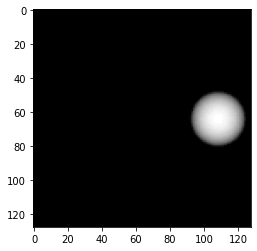

In [96]:
N=128
map_3d = raster_geometry.sphere([N,N,N],radius=N//8,position=.75).astype(np.float32)
rot = coords.EA_to_R3(phi=np.pi/4,theta=0)
map_3d_rot = geometry.rotate_map_3d(map_3d, rot,order=1)
doplt(map_3d_rot.sum(-1))

### benchmarking
* run time goes from 350 ms to ~2.5 seconds for 128^3 vs 256^3 voxels

In [49]:
np.random.seed(0)
phi, theta, psi = np.random.uniform(0,2*np.pi,size=3)
rot = coords.EA_to_R3(phi, theta, psi)
for N in [16,32,64,128,256]:
  map_3d = raster_geometry.sphere([N,N,N],radius=N//8,position=.75).astype(np.float32)
  %timeit geometry.rotate_map_3d(map_3d, rot,order=1)

1000 loops, best of 5: 505 µs per loop
100 loops, best of 5: 5.25 ms per loop
10 loops, best of 5: 42.4 ms per loop
1 loop, best of 5: 361 ms per loop
1 loop, best of 5: 3.25 s per loop


## masking (work in progress)
* we can also rotate some points (apply a mask). this makes us only interpolate points inside our mask and speeds things up.
* the idea is to only keep xyz coordinates that are close to the mask after rotated
  * however, it requires finding out which points will rotate into the mask, and this is expensive (perhaps more expensive than just not using the mask). 
  * there's an expensive step where we compute the kdtree for the $N^3$ cartesian voxel coordinates. However, this only needs to be done once for a given N and is independent of the rotation. There's a high memory requirement and N ~ 512 may be too much for some systems.

Text(0.5, 1.0, 'unrotated')

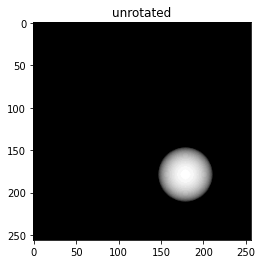

In [5]:
N=256
map_3d = raster_geometry.sphere([N,N,N],radius=N//8,position=.7).astype(np.float32)
#map_3d = raster_geometry.sphere([N,N,N],radius=N//10,position=.6).astype(np.float32)
doplt(map_3d.sum(-1)) ; plt.title('unrotated')

Text(0.5, 1.0, 'rotated')

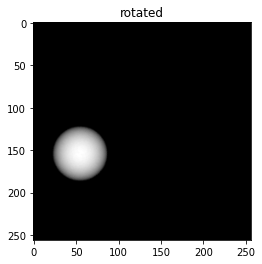

In [11]:
np.random.seed(1)
phi, theta, psi = np.random.uniform(0,2*np.pi,size=3)
rot = coords.EA_to_R3(phi, theta, psi)
map_3d_rot = geometry.rotate_map_3d(map_3d, rot, order=1)
doplt(map_3d_rot.sum(-1)) ; plt.title('rotated')

In [12]:
xyz = coords.coords_n_by_d(N=N,d=3)
xyz.shape

(16777216, 3)

Text(0.5, 1.0, 'mask (should encolse unrotated)')

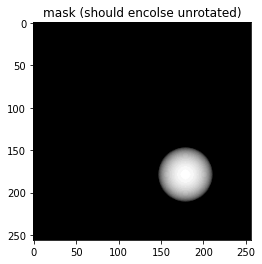

In [7]:
mask = map_3d > 0
doplt(mask.sum(-1)) ; plt.title('mask (should encolse unrotated)')

In [13]:
mask_xyz = xyz[mask.flatten()] # unrotated points in mask
mask_xyz.shape, mask.mean()
mask_xyz_rot = (rot.dot(mask_xyz.T) + N//2).T # roted points in mask. note here we used rot not rot.T
mask_xyz_rot # check values, they coordinates should match the rotated density
mask_xyz_rot

array([[151.23478053,  62.74397846, 137.36998538],
       [152.08689019,  62.25454608, 137.18460719],
       [149.0323806 ,  62.85577022, 137.74003557],
       ...,
       [158.91392331,  46.74887686, 198.71480986],
       [155.85941372,  47.350101  , 199.27023824],
       [156.71152338,  46.86066862, 199.08486005]])

In [ ]:
# only keep xyz coordinates that are close to mask after rotated

In [14]:
xyz_rot = (rot.T.dot(xyz.T) + N//2).T
xyz_rot.shape

(16777216, 3)

In [15]:
%time kd_tree1 = cKDTree(mask_xyz_rot) # small because mask
%time kd_tree2 = cKDTree(xyz + N//2) # large but can be precomputed because always the same (when rotate mask and compare)

CPU times: user 96.7 ms, sys: 1.73 ms, total: 98.4 ms
Wall time: 99.1 ms
CPU times: user 36.4 s, sys: 109 ms, total: 36.5 s
Wall time: 36.4 s


In [16]:
close_thresh = 2 # pixel tolerance for a point being included.
%time sdm = kd_tree1.sparse_distance_matrix(kd_tree2, 2)

CPU times: user 3.96 s, sys: 879 ms, total: 4.83 s
Wall time: 4.79 s


0.009533464908599854

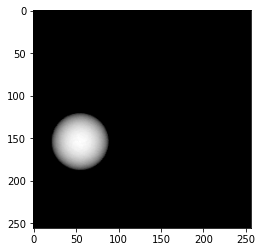

In [17]:
# close = (sdm.toarray().max(0) > 1).reshape(N,N,N) # these points rotate into mask
#%timeit (sdm.tocsc().max(0) > 1).toarray().reshape(N,N,N) # max operation in sparse to don't have memory issues.
# csc and coo faster than csr
#N csc coo csr
#32 2.33 2.34 2.45 ms
# 128 120 120 133 ms
close = (sdm.tocsc().max(0) > 1).toarray().reshape(N,N,N)
doplt(close.sum(-1))
close.mean()

In [18]:
xyz_rotate_into_mask = xyz_rot[close.flatten()]
xyz_rotate_into_mask.shape


(159945, 3)

In [19]:
%timeit map_coordinates(map_3d,xyz_rotate_into_mask.T,order=1)
map_3d_rot_flat = map_coordinates(map_3d,xyz_rotate_into_mask.T,order=1)
map_3d_rot_flat.shape, map_3d_rot_flat

100 loops, best of 5: 16.7 ms per loop


((159945,), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

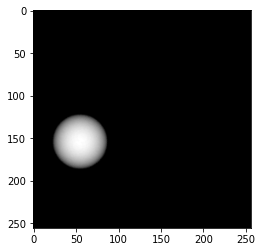

In [20]:
densit_3d_rot_flat = np.zeros(N**3)
densit_3d_rot_flat[close.flatten()] = map_3d_rot_flat # everything else zero
densit_3d_rot = densit_3d_rot_flat.reshape(N,N,N)
doplt(densit_3d_rot.sum(-1))